In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Swaptionvol


In [67]:
datafile = pd.read_excel('Invertir_Smile_Mercado_Swaption.xlsx')
FS = datafile.iloc[22,2]
Premium_put = datafile.iloc[10,4:11].values/10000
Premium_call = datafile.iloc[10,11:17].values/10000
K_put = datafile.iloc[11,4:11].values;
K_call = datafile.iloc[11,11:17].values;
K = np.concatenate((np.hstack(K_put),np.hstack(K_call)),axis=None)
Annuity = datafile.iloc[20,2]; Expiry = datafile.iloc[5,4]
ATMstrike = K[np.nonzero(K == FS)]

# Volatilidades a partir del modelo lognormal (Black)

Como hay strikes negativos habrá valores para los que el logaritmo no esté definido, por lo tanto aplico un shift al Forward Swap Rate y a los Strikes de $s=1\%$

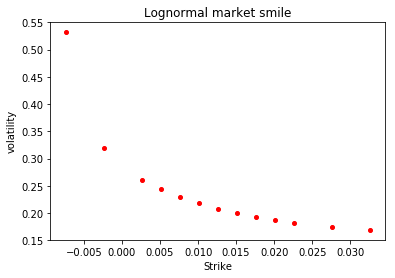

In [68]:
sigmacall2 = []; sigmaput2 = []; s = 0.01
for i in range(K_call.size):
    sigmacall2.append(Swaptionvol.SwaptionLognvol(FS,K_call[i],Annuity,Expiry,Premium_call[i],s,1))
for j in range(K_put.size):#range(K_put.size):
    sigmaput2.append(Swaptionvol.SwaptionLognvol(FS,K_put[j],Annuity,Expiry,Premium_put[j],s,-1))
sigmaMKT2 = np.asarray(sigmaput2 + sigmacall2)

# Plot of implied volatilies for each strike
plt.plot(K,sigmaMKT2,'ro',markersize=4); plt.title('Lognormal market smile');
plt.ylabel("volatility"); plt.xlabel("Strike");

# Calibración del (shifted) SABR (modelo Black)
Fijo los parámetros en los valores anteriores, $\beta=0.5$ y $s=1\%$, y realizo los mismos pasos que en el caso anterior pero con la volatilidad implícita correspondiente a este modelo

Los parámetros estimados: [alpha, rho, nu] =  [ 0.02704443 -0.26449433  0.31054476]


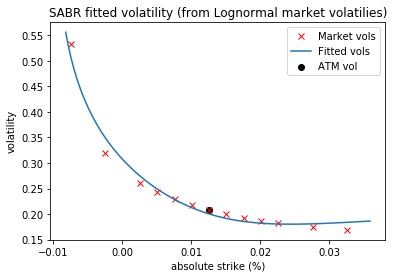

In [69]:
import SABRlognsmile
s = 0.01 ; beta = 0.5;
SABRBlparam = SABRlognsmile.SABRBlcalb(FS,K,sigmaMKT2,Expiry,beta,s)    #calibrate SABR

X = np.arange(min(K)*1.1, max(K)*1.1, (max(K)-min(K))/100)
estimatedvols = SABRlognsmile.SABRBlplot(SABRBlparam,FS,X,Expiry,beta,s)  #estimated volatilities

# Plot of fitted volatilities and market volatilities (Black model)
plt.figure()        #creates new figure
plt.plot(K,sigmaMKT2,'rx',label='Market vols')
plt.plot(X,estimatedvols,label='Fitted vols')
plt.title('SABR fitted volatility (from Lognormal market volatilies)'); plt.ylabel('volatility'); plt.xlabel("absolute strike (%)");
plt.scatter(ATMstrike,sigmaMKT2[np.nonzero(K == FS)],c="black",marker='o',label='ATM vol') #ATM
plt.legend(); print('Los parámetros estimados: [alpha, rho, nu] = ', SABRBlparam)

Los parámetros estimados: [alpha, rho, nu, beta] =  [ 0.06647076 -0.41069931  0.37722007  0.72962948]


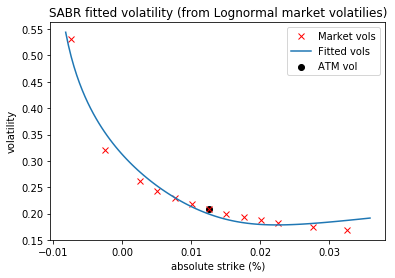

In [70]:
import SABRlognsmilebeta
s = 0.01;
SABRBlparam = SABRlognsmilebeta.SABRBlcalb(FS,K,sigmaMKT2,Expiry,s)    #calibrate SABR

X = np.arange(min(K)*1.1, max(K)*1.1, (max(K)-min(K))/100)
estimatedvols = SABRlognsmilebeta.SABRBlplot(SABRBlparam,FS,X,Expiry,s)  #estimated volatilities

# Plot of fitted volatilities and market volatilities (Black model)
plt.figure()        #creates new figure
plt.plot(K,sigmaMKT2,'rx',label='Market vols')
plt.plot(X,estimatedvols,label='Fitted vols')
plt.title('SABR fitted volatility (from Lognormal market volatilies)'); plt.ylabel('volatility'); plt.xlabel("absolute strike (%)");
plt.scatter(ATMstrike,sigmaMKT2[np.nonzero(K == FS)],c="black",marker='o',label='ATM vol') #ATM
plt.legend(); print('Los parámetros estimados: [alpha, rho, nu, beta] = ', SABRBlparam)

## Calibración del (shifted) SABR lognormal con $\alpha$ implícita

Ahora implemento el segundo método, donde el valor de $\alpha$ se obtiene a partir de la volatilidad ATM como función de $\rho$ y $\nu$, resolviendo en cada iteración del metodo de convergencia una ecuación de grado 3. De este polinomio cúbico se selecciona la raíz real positiva más pequeña. Los valores iniciales utilizados en el algoritmo de minimización (*L-BFGS-B*) son los utilizados anteriormente $(\rho,\nu) = (0.01,0.01)$, al igual que las restricciones

Los parámetros estimados: [alpha, rho, nu] =  [0.014369191883977107, -0.022375780363276504, 0.04245838073835789]


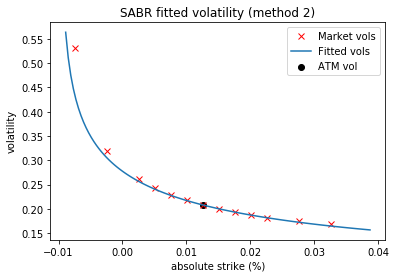

In [71]:
import SABRlognmethod2
s = 0.01; beta = 0.3;
SABRBlparam = SABRlognmethod2.SABRBlcalb(FS,K,sigmaMKT2,Expiry,beta,s)    #calibrate SABR

def alpha(rho,nu):
    raices = np.roots([(1-beta)**2*Expiry/(24*(FS+s)**(2-2*beta)),beta*rho*nu*Expiry/(4*(FS+s)**(1-beta)),
             1 + (2-3*rho**2)*nu**2*Expiry/24,-sigmaMKT2[np.nonzero(K == FS)]*(FS+s)**(1-beta)])
    raices = raices[np.isreal(raices) == 1] #returns only real numbers
    raiz = np.amin(raices[raices>0])     #returns minimum positive value
    return raiz.real

SABRBlparam = [alpha(SABRBlparam[0],SABRBlparam[1]),SABRBlparam[0],SABRBlparam[1]]

X = np.arange(min(K)*1.2, max(K)*1.2, (max(K)-min(K))/100)
estimatedvols = SABRlognmethod2.SABRBlplot(SABRBlparam,FS,X,Expiry,beta,s)  #estimated volatilities

# Plot of fitted volatilities and market volatilities (Black model)
plt.figure()        #creates new figure
plt.plot(K,sigmaMKT2,'rx',label='Market vols')
plt.plot(X,estimatedvols,label='Fitted vols')
plt.title('SABR fitted volatility (method 2)'); plt.ylabel('volatility'); plt.xlabel("absolute strike (%)");
plt.scatter(ATMstrike,sigmaMKT2[np.nonzero(K == FS)],c="black",marker='o',label='ATM vol') #ATM
plt.legend(); print('Los parámetros estimados: [alpha, rho, nu] = ', SABRBlparam)

# Volatilidades a partir del modelo normal (Bachelier)

Volatilidades ímplicitas en los Swaption según el modelo Normal (Bachelier). Para obtenerlas he utilizado el método de Newton-Raphson.

In [72]:
sigmacall = []; sigmaput = [];
for i in range(K_call.size):
    sigmacall.append(Swaptionvol.SwaptionNormalvol(FS,K_call[i],Annuity,Expiry,Premium_call[i],1))
for j in range(K_put.size):
    sigmaput.append(Swaptionvol.SwaptionNormalvol(FS,K_put[j],Annuity,Expiry,Premium_put[j],-1))
sigmaMKT = np.asarray(sigmaput + sigmacall)

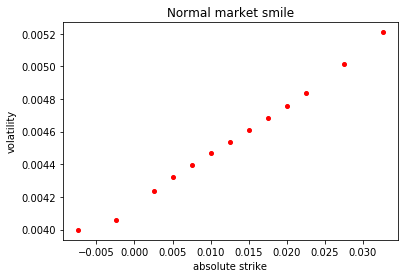

In [73]:
sigmaMKT = np.asarray(sigmaput + sigmacall)
plt.plot(K,sigmaMKT,'ro',markersize=4); plt.title('Normal market smile');
plt.ylabel("volatility"); plt.xlabel("absolute strike");

# Calibración del SABR (normal)
A partir de la volatilidad de mercado implícita en un swaption 20Y_20Y obtenida a través del modelo normal (Bachelier).
Parámetros fijados: $\beta = 0.5$ y $s = 1\%$. Como minimizador de la función objetivo he utilizado el método *L-BFGS-B* y como condiciones iniciales, para $\alpha$ he utilizado el valor de la volatilidad de mercado para un swaption ATM, y para los otros dos parámetros $\rho$ y $\nu$ el valor 0.01, con las condiciones de contorno clásicas

Los parámetros estimados: [alpha, rho, nu] =  [ 0.34408899 -0.58097888  0.16243725]


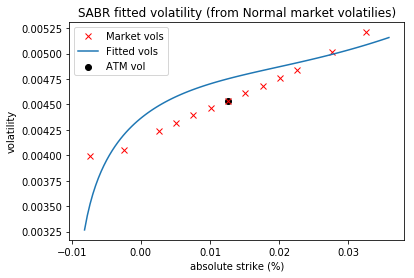

In [74]:
import SABRnormalsmile
s = 0.01; beta = 0.5;
SABRBlparam = SABRnormalsmile.SABRNormalcalb(FS*100,K*100,sigmaMKT*100,Expiry,beta,s*100)    #calibrate SABR
X = np.arange(min(K)*1.1, max(K)*1.1, (max(K)-min(K))/100)
estimatedvols = SABRnormalsmile.SABRNormalplot(SABRBlparam,FS*100,X*100,Expiry,beta,s*100)  #estimated volatilities

# Plot of fitted volatilities and market volatilities (Normal model)
plt.figure()        #creates new figure
plt.plot(K,sigmaMKT,'rx',label='Market vols')
plt.plot(X,np.asarray(estimatedvols)/100,label='Fitted vols')
plt.title('SABR fitted volatility (from Normal market volatilies)'); plt.ylabel('volatility'); plt.xlabel("absolute strike (%)");
plt.scatter(ATMstrike,sigmaMKT[np.nonzero(K == FS)],c="black",marker='o',label='ATM vol') #ATM
plt.legend(); print('Los parámetros estimados: [alpha, rho, nu] = ', SABRBlparam)

Y ahora realizo la calibración añadiendo $\beta$ como un parámetro más a estimar $(s=1)$

Los parámetros estimados: [alpha, rho, nu, beta] =  [ 0.37327295 -0.61124662  0.09164037  0.37440007]


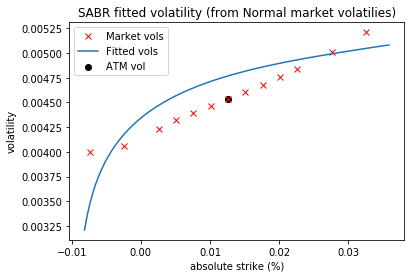

In [75]:
# Bachelier (Normal) SABR parametrization (estimating beta)
import SABRnormalsmilebeta
s = 0.01;
SABRBlparam = SABRnormalsmilebeta.SABRNormalcalb(FS*100,K*100,sigmaMKT*100,Expiry,s*100)    #calibrate SABR

X = np.arange(min(K)*1.1, max(K)*1.1, (max(K)-min(K))/100)
estimatedvols = SABRnormalsmilebeta.SABRNormalplot(SABRBlparam,FS*100,X*100,Expiry,s*100)  #estimated volatilities

# Plot of fitted volatilities and market volatilities (Normal model)
plt.figure()        #creates new figure
plt.plot(K,sigmaMKT,'rx',label='Market vols')
plt.plot(X,np.asarray(estimatedvols)/100,label='Fitted vols')
plt.title('SABR fitted volatility (from Normal market volatilies)'); plt.ylabel('volatility'); plt.xlabel("absolute strike (%)");
plt.scatter(ATMstrike,sigmaMKT[np.nonzero(K == FS)],c="black",marker='o',label='ATM vol') #ATM
plt.legend(); print('Los parámetros estimados: [alpha, rho, nu, beta] = ', SABRBlparam)

Por lo tanto, como la $\beta$ es similar pero si no es estima se ajusta mejor al mercado, continuo fijando la $\beta$.
Aquí es donde me entran dudas, yo creo que está bien programado pero no parece que ajuste bien el smile.

## Calibración del (shifted) SABR con $\alpha$ implícita

Los parámetros estimados: [alpha, rho, nu] =  [0.8772557236295438, -0.9999, 0.20301882943812066]


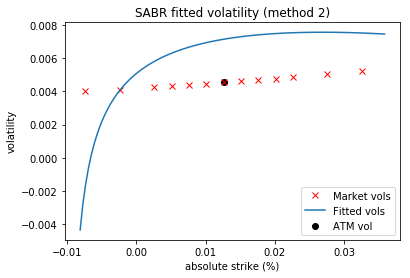

In [76]:
import SABRnormalmethod2
s = 0.01; beta = 0.3;
SABRBlparam = SABRnormalmethod2.SABRNormalcalb(FS*100,K*100,sigmaMKT*100,Expiry,beta,s*100)    #calibrate SABR

def alpha(rho,nu):
    raices = np.roots([(1-beta)**2*Expiry/(24*((FS+s)*100)**(2-2*beta)),beta*rho*nu*Expiry/(4*((FS+s)*100)**(1-beta)),
             1 + (2-3*rho**2)*nu**2*Expiry/24,-sigmaMKT[np.nonzero(K == FS)]*100*((FS+s)*100)**(1-beta)])
    raices = raices[np.isreal(raices) == 1] #returns only real numbers
    raiz = np.amin(raices[raices>0])     #returns minimum positive value
    return raiz.real

SABRBlparam = [alpha(SABRBlparam[0],SABRBlparam[1]),SABRBlparam[0],SABRBlparam[1]]

X = np.arange(min(K)*1.1, max(K)*1.1, (max(K)-min(K))/100)
estimatedvols = SABRnormalmethod2.SABRNormalplot(SABRBlparam,FS*100,X*100,Expiry,beta,s*100)  #estimated volatilities

# Plot of fitted volatilities and market volatilities (Normal model)
plt.figure()        #creates new figure
plt.plot(K,sigmaMKT,'rx',label='Market vols')
plt.plot(X,np.asarray(estimatedvols)/100,label='Fitted vols')
plt.title('SABR fitted volatility (method 2)'); plt.ylabel('volatility'); plt.xlabel("absolute strike (%)");
plt.scatter(ATMstrike,sigmaMKT[np.nonzero(K == FS)],c="black",marker='o',label='ATM vol') #ATM
plt.legend(); print('Los parámetros estimados: [alpha, rho, nu] = ', SABRBlparam)

La calibración del SABR realizada a partir de los datos del modelo normal es muy inexacta o incorrecta. Yo creo se puede deber al minimizador utilizado, pues la volatilidad a ajustar es más pequeña, por tanto la función objetivo tendrá que reducir su valor más que la anterior. Esto puede hacer que el minimizador no converga a la solución antes de alcanzar su tolerancia mínima, la cual he intentado cambiar pero puede que no lo haya hecho correctamente. He intentado paliar esto multiplicando el Forward Swap Rate (FS) , strikes, shift y volatilidades normales por 100, pero sigue sin ajustarse como lo hace en el caso lognormal.
En resumen, creo que mi fallo está o en el uso de los parámetros del minimizador, o en los valores iniciales o las unidades a introducir en el minimizador